<a href="https://colab.research.google.com/github/Frecherenkel60/RandomForestRangers/blob/main/DataMining_RandomForestRangers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Rangers - Predicting Car Sales Prices

In [57]:
# Install dependencies
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [59]:
#dataset = pd.read_csv('./data/used_car_prices_generated.csv')
dataset = pd.read_csv('./data/used_car_prices_original.csv')

print(dataset.dtypes)
dataset.head(10)

brand           object
model           object
model_year       int64
milage          object
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price           object
dtype: object


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
5,Acura,ILX 2.4L,2016,"136,397 mi.",Gasoline,2.4 Liter,F,Silver,Ebony.,None reported,NaN,"$14,798"
6,Audi,S3 2.0T Premium Plus,2017,"84,000 mi.",Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,"$31,000"
7,BMW,740 iL,2001,"242,000 mi.",Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,None reported,Yes,"$7,300"
8,Lexus,RC 350 F Sport,2021,"23,436 mi.",Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,"$41,927"
9,Tesla,Model X Long Range Plus,2020,"34,000 mi.",NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,"$69,950"


## Preprocessing
### Ensure consistent data formatting

In [60]:
df = dataset.copy()

# Function to reformat numeric attributes with non-numeric elements such as currency symbols
def reformat_non_numeric(text):
    if not isinstance(text, object):
        return float(text)
    return float(re.sub(r'[^\d.]', '', text))

# Function to reformat the clean title column
def reformat_clean_title(text):
    return 1 if text == 'Yes' else 0

# Function to reformat the accident column
def reformat_accident(text):
    return 0 if text == '' or text == 'None reported' else 1

# Reformat the existing columns
df['clean_title'] = df['clean_title'].apply(reformat_clean_title)
df['price'] = df['price'].apply(reformat_non_numeric)
df['milage'] = df['milage'].apply(reformat_non_numeric)
df['accident'] = df['accident'].apply(reformat_accident)

dataset = df.copy()

### Extract additional features

In [61]:
df = dataset.copy()

# Function to extract number of cylinders
def extract_cylinders(text):
    match = re.search(r'(\d+)\s*Cylinder', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract horsepower
def extract_hp(text):
    match = re.search(r'(\d+(?:\.\d+)?)\s*HP', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract cubic capacity
def extract_capacity(text):
    match = re.search(r'(\d+(?:\.\d+)?)\s*L', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract whether the car has a turbo
def extract_turbo(text):
    match = re.search(r'Turbo', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract gear type
def extract_gear_type(text):
    match_automatic = re.search(r'Automatic|A/T', text, re.IGNORECASE)
    match_manual = re.search(r'Manual|M/T', text, re.IGNORECASE)
    return 'Automatic' if match_automatic else 'Manual' if match_manual else None

# Function to extract the number of gears
def extract_gears(text):
    match = re.search(r'(\d+)-Speed\b', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract whether the car has dual shift
def extract_dual_shift(text):
    match = re.search(r'Dual Shift', text, re.IGNORECASE)
    return 1 if match else 0

# Apply the extraction functions to create new columns
df['cylinders'] = df['engine'].apply(extract_cylinders)
df['horsepower'] = df['engine'].apply(extract_hp)
df['cubic_capacity'] = df['engine'].apply(extract_capacity)
df['turbo'] = df['engine'].apply(extract_turbo)
df['gear_type'] = df['transmission'].apply(extract_gear_type)
df['gears'] = df['transmission'].apply(extract_gears)
df['dual_shift'] = df['transmission'].apply(extract_dual_shift)

dataset = df.copy()

In [62]:
# Missing values per feature only print if there are any
missing_values = dataset.isnull().sum()
missing_values = missing_values[missing_values > 0]
print('Missing values per feature:')
if not missing_values.empty:
    print(missing_values)

# Fill in missing values with the median
dataset['cylinders'] = dataset['cylinders'].fillna(dataset['cylinders'].median())
dataset['horsepower'] = dataset['horsepower'].fillna(dataset['horsepower'].median())
dataset['cubic_capacity'] = dataset['cubic_capacity'].fillna(dataset['cubic_capacity'].median())
dataset['gears'] = dataset['gears'].fillna(dataset['gears'].median())

# Fill in missing values with extra category
dataset['gear_type'] = dataset['gear_type'].fillna('N/A')
dataset['gear_type'] = dataset['gear_type'].fillna('N/A')

# Print first 10 columns
dataset.head(10)

Missing values per feature:
fuel_type          170
cylinders          945
horsepower         808
cubic_capacity     217
gear_type          489
gears             1853
dtype: int64


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,cylinders,horsepower,cubic_capacity,turbo,gear_type,gears,dual_shift
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,1,1,10300.0,6.0,300.0,3.7,0,Automatic,6.0,0
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,1,1,38005.0,6.0,310.0,3.8,0,Automatic,8.0,0
2,Lexus,RX 350 RX 350,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,0,0,54598.0,6.0,310.0,3.5,0,Automatic,7.0,0
3,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,0,1,15500.0,6.0,354.0,3.5,0,Automatic,7.0,0
4,Audi,Q3 45 S line Premium Plus,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,0,0,34999.0,6.0,310.0,2.0,1,Automatic,8.0,0
5,Acura,ILX 2.4L,2016,136397.0,Gasoline,2.4 Liter,F,Silver,Ebony.,0,0,14798.0,6.0,310.0,2.4,0,N/A,7.0,0
6,Audi,S3 2.0T Premium Plus,2017,84000.0,Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,0,1,31000.0,4.0,292.0,2.0,0,Automatic,6.0,0
7,BMW,740 iL,2001,242000.0,Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,0,1,7300.0,8.0,282.0,4.4,0,Automatic,7.0,0
8,Lexus,RC 350 F Sport,2021,23436.0,Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,0,1,41927.0,6.0,311.0,3.5,0,Automatic,6.0,0
9,Tesla,Model X Long Range Plus,2020,34000.0,NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,0,1,69950.0,6.0,534.0,3.5,0,Automatic,7.0,0


## Some interesting plots and insights from the dataset

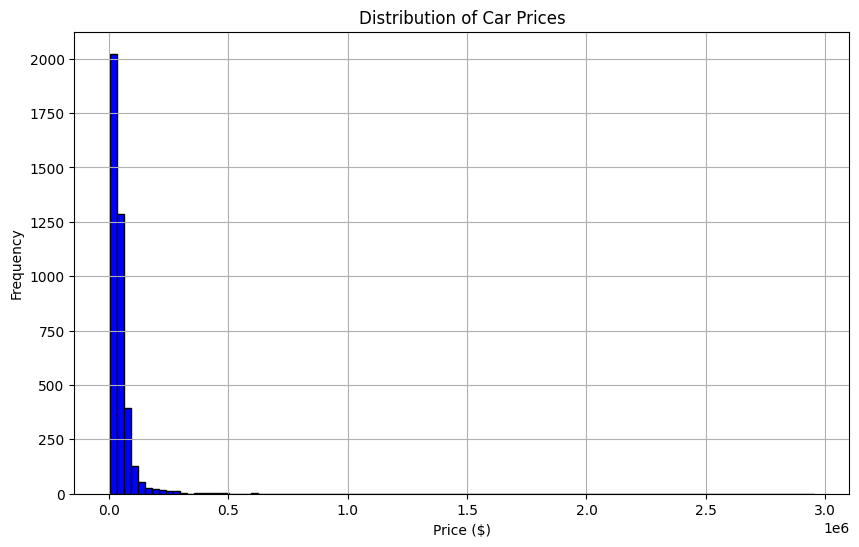

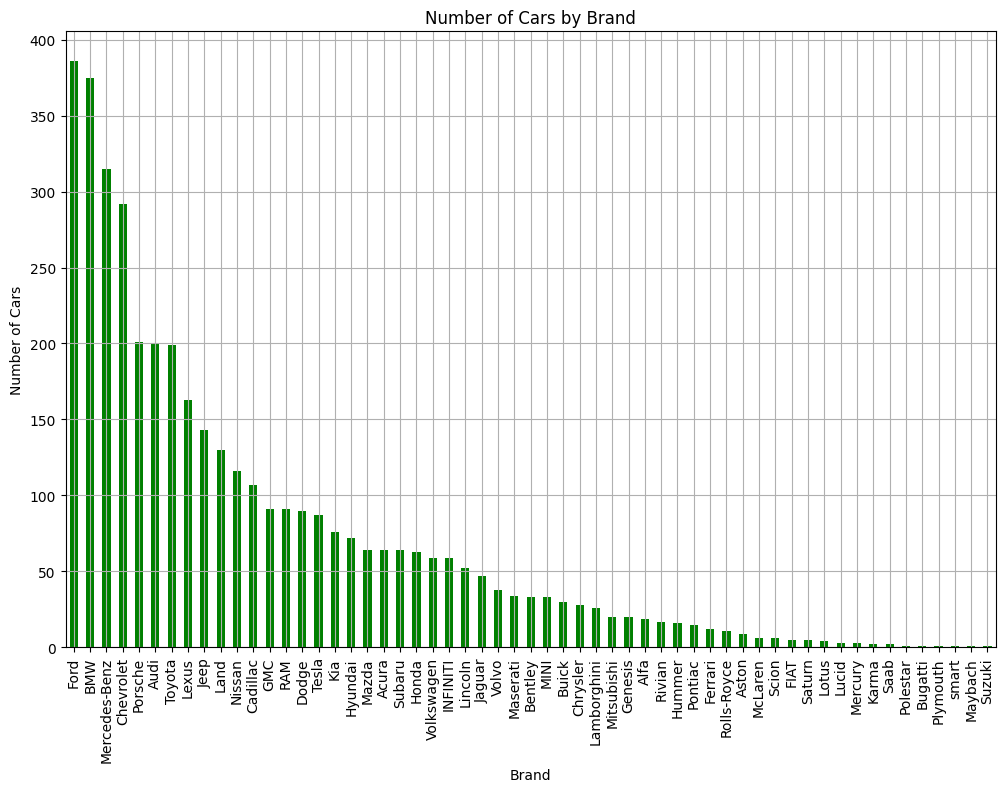

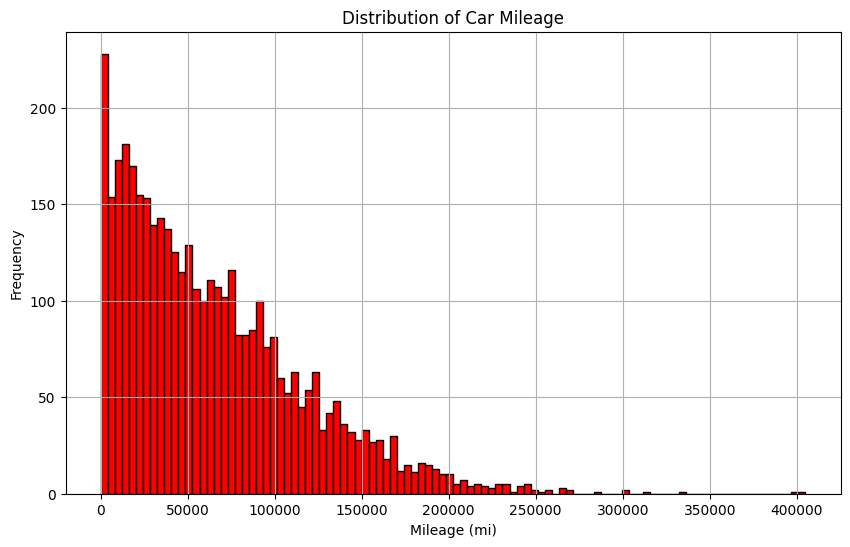

In [63]:
# Plot distribution of car prices
plt.figure(figsize=(10, 6))
plt.hist(dataset['price'].dropna(), bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Car Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot number of cars by brand
plt.figure(figsize=(12, 8))
dataset['brand'].value_counts().plot(kind='bar', color='green')
plt.title('Number of Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Cars')
plt.grid(True)
plt.show()

# Plot distribution of mileage
plt.figure(figsize=(10, 6))
plt.hist(dataset['milage'].dropna(), bins=100, color='red', edgecolor='black')
plt.title('Distribution of Car Mileage')
plt.xlabel('Mileage (mi)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


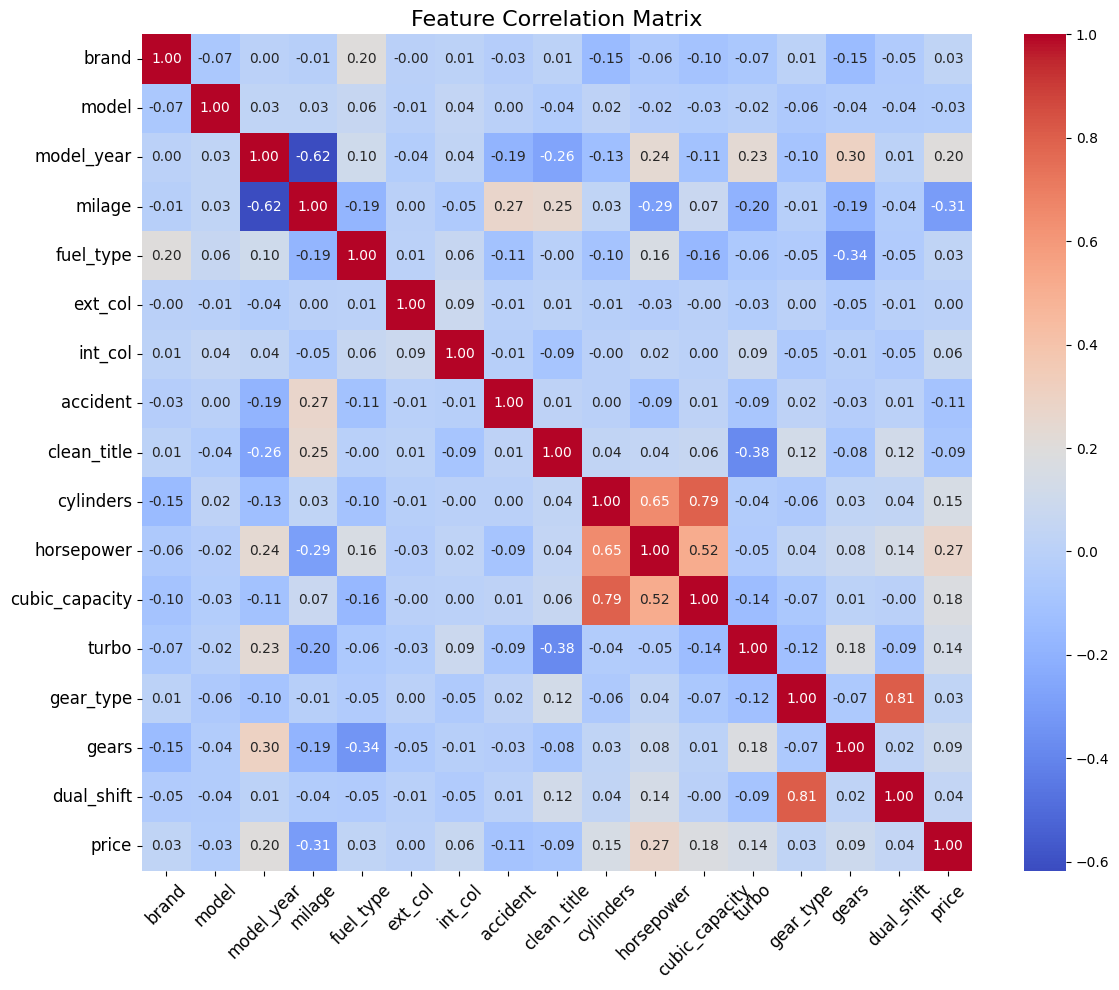

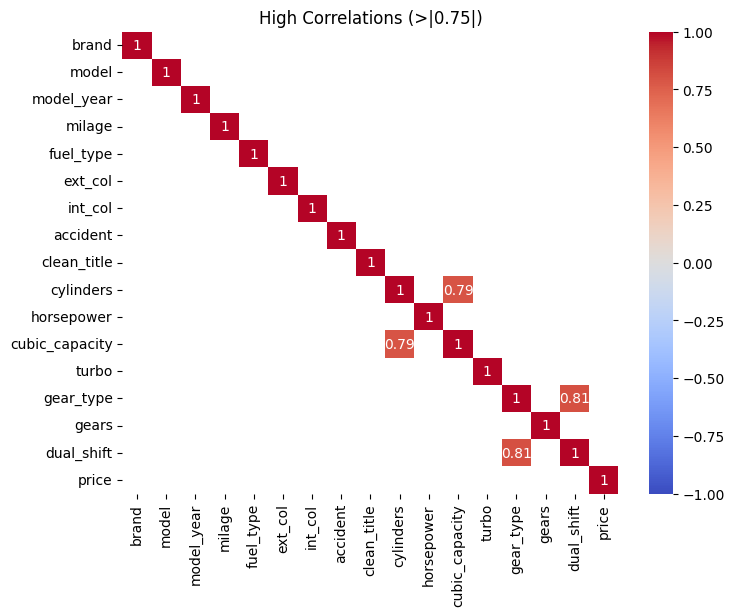

In [64]:
# Prepare data for models
dataset = dataset[[
    'brand',
    'model',
    'model_year',
    'milage',
    'fuel_type',
    'ext_col',
    'int_col',
    'accident',
    'clean_title',
    'cylinders',
    'horsepower',
    'cubic_capacity',
    'turbo',
    'gear_type',
    'gears',
    'dual_shift',
    'price'
]]
# Encode categorical variables using label encoding
label_encoders = {}
for column in dataset.select_dtypes(include=['object']).columns:
    label_encoders[column] = preprocessing.LabelEncoder()
    dataset[column] = label_encoders[column].fit_transform(dataset[column])
    dataset[column] = label_encoders[column].fit_transform(dataset[column])

# Correlation matrix
correlation_matrix = dataset.corr()
plt.figure(figsize=(12, 10))  # Adjust the width and height
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16)  # Increase title font size
plt.xticks(fontsize=12, rotation=45)  # Adjust tick font size and rotate labels
plt.yticks(fontsize=12)
plt.tight_layout()  # Ensure everything fits
plt.show()

# Only high correlations above 0,8
threshold = 0.75
mask = np.abs(correlation_matrix) < threshold
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    mask=mask,
    cmap='coolwarm',
    cbar=True,
    vmin=-1, vmax=1
)
plt.title("High Correlations (>|0.75|)")
plt.show()

The attributes `dual_shift` and `gear_type` are highly correlated (seems like a lot of the transmissions have the same `dual_shift` and `gear_type` attribute in `transmission`), one of them should definitely be removed. Same goes for `cubic_capacity` and `cylinders`, which were derived from `engine`.

## Train Test Fold Split

In [65]:
from sklearn.model_selection import KFold

# Define the features and target variable
X = dataset.drop(columns=['price'])
y = dataset['price']

# Define the number of folds
k = 5

# Initialize KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

print('X_train_fold shape:', X_train_fold.shape)
print('X_test_fold shape:', X_test_fold.shape)

X_train_fold shape: (3208, 16)
X_test_fold shape: (801, 16)


## Model Training
### Linear Regression

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Initialize the model
lr_model = LinearRegression()
scaler = StandardScaler()

# Data structure to store the results
benchmark_lr_models = []
best_lr_model = None

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Scale the data
    #X_train_fold_scaled = scaler.fit_transform(X_train_fold, y_train_fold)
    #X_test_fold_scaled = scaler.transform(X_test_fold)
    X_train_fold_scaled = pd.DataFrame(scaler.fit_transform(X_train_fold), columns=X_train_fold.columns)
    X_test_fold_scaled = pd.DataFrame(scaler.transform(X_test_fold), columns=X_test_fold.columns)

    # Train the model
    lr_model.fit(X_train_fold_scaled, y_train_fold)

    # Make predictions
    y_lr_pred = lr_model.predict(X_test_fold_scaled)

    # Calculate metrics
    lr_mse = mean_squared_error(y_test_fold, y_lr_pred)
    lr_r2 = r2_score(y_test_fold, y_lr_pred)

    benchmark_lr_models.append({
        'MSE': lr_mse,
        'R2': lr_r2
    })

    if not best_lr_model or lr_mse < best_lr_model['MSE']:
        best_lr_model = {
            'model': lr_model,
            'X_train': X_train_fold_scaled,
            'X_test': X_test_fold_scaled,
            'y_train': y_train_fold,
            'y_test': y_test_fold,
            'MSE': lr_mse,
            'R2': lr_r2
        }

# Convert results to DataFrame
benchmark_lr_models_df = pd.DataFrame(benchmark_lr_models)

# round mean values to 2 decimal places
print('Mean MSE :', round(benchmark_lr_models_df['MSE'].mean(), 2))
print('Mean R2:', round(benchmark_lr_models_df['R2'].mean(), 2))

print('Best model MSE:', round(best_lr_model['MSE'], 2))
print('Best model R2:', round(best_lr_model['R2'], 2))

Mean MSE : 5286054095.76
Mean R2: 0.25
Best model MSE: 1421677821.23
Best model R2: 0.33


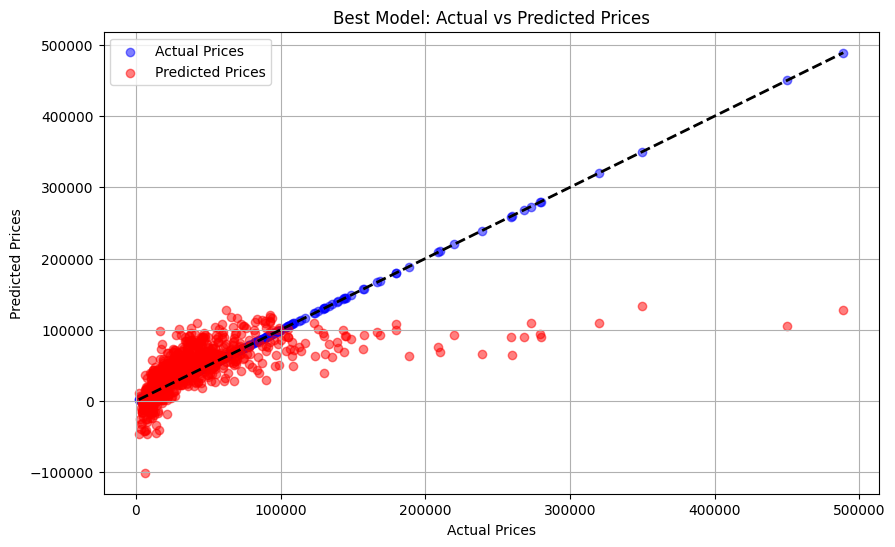

In [83]:
# Scatter plot for the best model
plt.figure(figsize=(10, 6))

# Plot actual test points
plt.scatter(best_lr_model['y_test'], best_lr_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted points
plt.scatter(best_lr_model['y_test'], best_lr_model['model'].predict(best_lr_model['X_test']), color='red', alpha=0.5, label='Predicted Prices')

# Add a reference line
plt.plot([best_lr_model['y_test'].min(), best_lr_model['y_test'].max()], [best_lr_model['y_test'].min(), best_lr_model['y_test'].max()], 'k--', lw=2)

# Add a title and labels
plt.title('Best Model: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

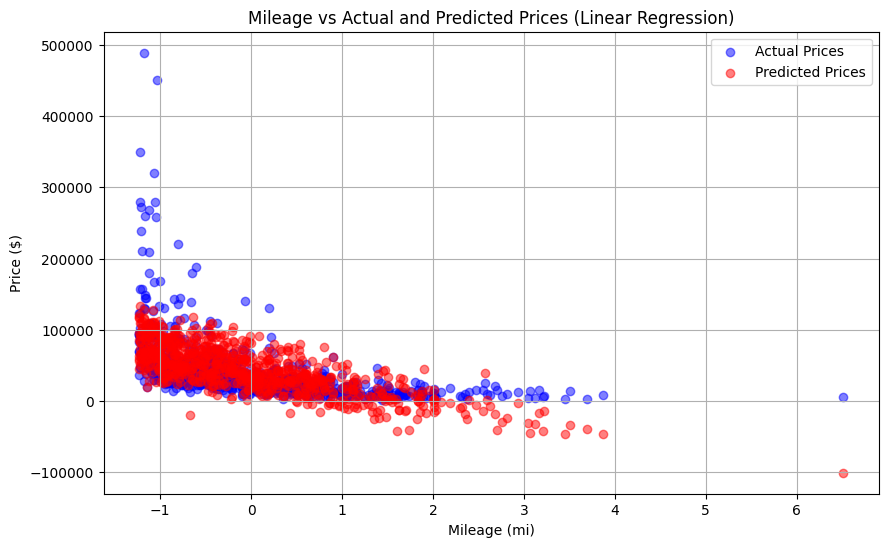

In [84]:
# Scatter plot for mileage vs actual and predicted prices using the best linear regression model
plt.figure(figsize=(10, 6))

# Plot actual prices
plt.scatter(best_lr_model['X_test']['milage'], best_lr_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted prices
plt.scatter(best_lr_model['X_test']['milage'], best_lr_model['model'].predict(best_lr_model['X_test']), color='red', alpha=0.5, label='Predicted Prices')

# Add a title and labels
plt.title('Mileage vs Actual and Predicted Prices (Linear Regression)')
plt.xlabel('Mileage (mi)')
plt.ylabel('Price ($)')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

## Polynomial Regression

In [69]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Define the degree of the polynomial
degree = 3

# Initialize the polynomial features transformer
poly = PolynomialFeatures(degree=degree)

# Initialize the model
poly_model = LinearRegression()

# Data structure to store the results
benchmark_poly_models = []
best_poly_model = None

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Transform the features to polynomial features
    X_train_poly = poly.fit_transform(X_train_fold)
    X_test_poly = poly.transform(X_test_fold)

    # Train the model
    poly_model.fit(X_train_poly, y_train_fold)

    # Make predictions
    y_poly_pred = poly_model.predict(X_test_poly)

    # Calculate metrics
    poly_mse = mean_squared_error(y_test_fold, y_poly_pred)
    poly_r2 = r2_score(y_test_fold, y_poly_pred)

    benchmark_poly_models.append({
        'MSE': poly_mse,
        'R2': poly_r2
    })

    if not best_poly_model or poly_mse < best_poly_model['MSE']:
        best_poly_model = {
            'model': poly_model,
            'X_train': X_train_fold,
            'X_test': X_test_fold,
            'y_train': y_train_fold,
            'y_test': y_test_fold,
            'MSE': poly_mse,
            'R2': poly_r2
        }

# Convert results to DataFrame
benchmark_poly_models_df = pd.DataFrame(benchmark_poly_models)

# round mean values to 2 decimal places
print('Mean MSE :', round(benchmark_poly_models_df['MSE'].mean(), 2))
print('Mean R2:', round(benchmark_poly_models_df['R2'].mean(), 2))

print('Best model MSE:', round(best_poly_model['MSE'], 2))
print('Best model R2:', round(best_poly_model['R2'], 2))

Mean MSE : 6919746109.3
Mean R2: -0.54
Best model MSE: 3523228786.45
Best model R2: -0.12


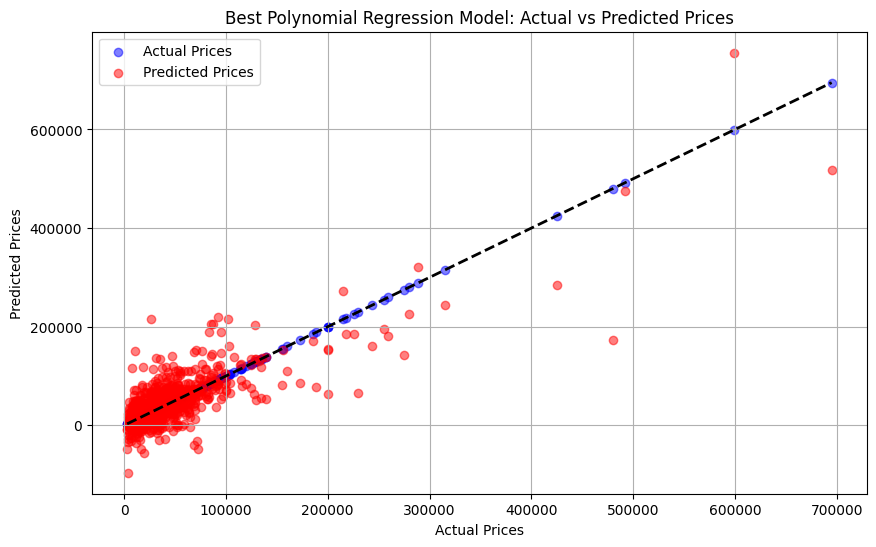

In [70]:
# Scatter plot for the best polynomial regression model
plt.figure(figsize=(10, 6))

# Plot actual test points
plt.scatter(best_poly_model['y_test'], best_poly_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted points
plt.scatter(best_poly_model['y_test'], best_poly_model['model'].predict(poly.transform(best_poly_model['X_test'])), color='red', alpha=0.5, label='Predicted Prices')

# Add a reference line
plt.plot([best_poly_model['y_test'].min(), best_poly_model['y_test'].max()], [best_poly_model['y_test'].min(), best_poly_model['y_test'].max()], 'k--', lw=2)

# Add a title and labels
plt.title('Best Polynomial Regression Model: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

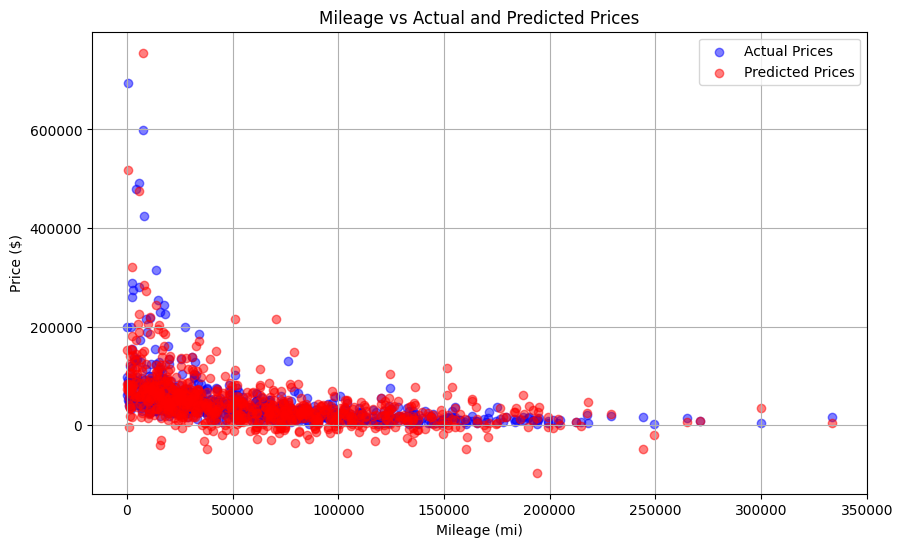

In [71]:
# Scatter plot for mileage vs actual and predicted prices using the best polynomial regression model
plt.figure(figsize=(10, 6))

# Plot actual prices
plt.scatter(best_poly_model['X_test']['milage'], best_poly_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted prices
plt.scatter(best_poly_model['X_test']['milage'], best_poly_model['model'].predict(poly.transform(best_poly_model['X_test'])), color='red', alpha=0.5, label='Predicted Prices')

# Add a title and labels
plt.title('Mileage vs Actual and Predicted Prices')
plt.xlabel('Mileage (mi)')
plt.ylabel('Price ($)')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()